In [31]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import os

# Define the URL
url = "https://data.ceda.ac.uk/badc/ukmo-hadobs/data/insitu/MOHC/HadOBS/HadUK-Grid/v1.2.0.ceda/60km"

# Send an HTTP GET request to the URL
response = requests.get(url)

# Parse the HTML content of the webpage
soup = BeautifulSoup(response.text, "html.parser")

# Create a directory to save the downloaded files
if not os.path.exists("downloaded_files"):
    os.makedirs("downloaded_files")

# Find all file links that end with .nc
file_links = [link.get("href") for link in soup.find_all("a") if link.get("href").endswith(".nc")]

# Iterate through the file links and download the files
for file_link in file_links:
    file_url = f"{url}/{file_link}"
    file_name = os.path.join("downloaded_files", file_link)
    
    response = requests.get(file_url)
    
    with open(file_name, "wb") as file:
        file.write(response.content)

# Create a dataframe with the downloaded file information
data = pd.DataFrame({
    "Filename": file_links,
    "File URL": [f"{url}/{file_link}" for file_link in file_links]
})


print(data)



Empty DataFrame
Columns: [Filename, File URL]
Index: []


In [36]:
import xarray as xr


# Open the netcdf file using xarray
ds = xr.open_dataset('sfcWind_hadukgrid_uk_1km_ann-20y_198101-200012.nc')

# Convert the data to a pandas dataframe
df = ds.to_dataframe()

# reset the index to a simpler index
df.reset_index(inplace=True)


print(df.head())


df.to_csv('wind_data_met.csv', index=False)

        time  projection_y_coordinate  projection_x_coordinate  bnds  sfcWind  \
0 1981-07-01                -199500.0                -199500.0     0      NaN   
1 1981-07-01                -199500.0                -199500.0     1      NaN   
2 1981-07-01                -199500.0                -198500.0     0      NaN   
3 1981-07-01                -199500.0                -198500.0     1      NaN   
4 1981-07-01                -199500.0                -197500.0     0      NaN   

   transverse_mercator  time_bnds  projection_y_coordinate_bnds  \
0          -2147483647 1981-01-01                     -200000.0   
1          -2147483647 2000-12-31                     -199000.0   
2          -2147483647 1981-01-01                     -200000.0   
3          -2147483647 2000-12-31                     -199000.0   
4          -2147483647 1981-01-01                     -200000.0   

   projection_x_coordinate_bnds   latitude  longitude  
0                     -200000.0  47.824377 -10.012910 

In [ ]:
df['sfcWind'][100]

In [ ]:
print(df.tail())

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Embedding, LSTM, Bidirectional, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, GlobalMaxPool1D
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import scipy.stats as stats
import os
import sys

In [2]:
wind_speed = pd.read_csv("uk 2019-01-01 to 2021-09-26.csv")

In [3]:
wind_speed.shape

(1000, 33)

In [4]:
wind_speed.tail()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
995,uk,2021-09-22,22.1,11.1,16.0,22.1,11.1,16.0,11.9,78.5,...,7.2,5,NaN,2021-09-22T06:46:44,2021-09-22T18:58:39,0.55,Rain,Clear conditions throughout the day with after...,rain,"03769099999,03680099999,D5621,03660099999,0367..."
996,uk,2021-09-23,20.8,12.1,16.2,20.8,12.1,16.2,13.2,82.7,...,7.3,5,NaN,2021-09-23T06:48:21,2021-09-23T18:56:21,0.58,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"03769099999,03680099999,D5621,03672099999,0378..."
997,uk,2021-09-24,23.1,13.1,17.4,23.1,13.1,17.4,13.4,79.2,...,7.3,6,NaN,2021-09-24T06:49:58,2021-09-24T18:54:03,0.61,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"03769099999,03680099999,D5621,03660099999,0367..."
998,uk,2021-09-25,18.6,14.3,16.8,18.6,14.3,16.8,15.2,90.4,...,2.6,1,NaN,2021-09-25T06:51:34,2021-09-25T18:51:44,0.64,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"03769099999,03680099999,D5621,03672099999,0378..."
999,uk,2021-09-26,22.1,13.6,17.2,22.1,13.6,17.2,14.3,84.3,...,4.1,2,NaN,2021-09-26T06:53:11,2021-09-26T18:49:26,0.68,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"03769099999,03680099999,D5621,03672099999,0378..."


In [5]:
print(wind_speed['sealevelpressure'].unique())
print(wind_speed['windgust'].unique())
print(wind_speed['icon'].unique())

[1035.6 1043.  1043.2 1042.3 1039.1 1036.8 1032.3 1028.1 1029.6 1030.6
 1030.2 1023.1 1014.3 1020.3 1019.5 1006.1 1011.3 1016.5 1010.  1017.9
 1021.3 1002.1 1002.6 1011.7 1014.   991.8 1005.8 1000.   995.8  991.5
  987.7 1006.8 1023.  1018.7 1023.2 1006.2  999.4 1000.5  997.8 1023.4
 1033.3 1033.2 1032.  1027.1 1022.8 1016.1 1015.5 1018.8 1020.1 1026.4
 1034.6 1033.9 1036.2 1032.5 1024.9 1016.  1018.2 1010.2  998.4  994.4
 1002.5  989.9  992.6 1009.8 1012.2 1009.1 1022.9 1007.1 1008.  1007.3
 1005.3 1020.5 1027.4 1033.  1028.9 1031.4 1031.3 1032.6 1034.2 1035.1
 1029.1 1024.3 1019.6 1004.9  999.   995.2 1001.8 1005.4 1008.1 1010.9
 1013.9 1019.3 1025.7 1027.  1025.6 1020.4 1015.1 1019.4 1020.6 1006.5
  997.5  994.2  999.2 1009.  1009.6 1019.7 1025.9 1024.6 1018.5 1014.7
 1019.1 1025.8 1022.1 1014.6  995.   997.1 1008.6 1039.5 1026.7 1009.4
 1006.7 1012.5 1017.  1013.7 1010.6 1012.3 1020.8 1023.7 1010.4 1012.4
 1006.6 1005.9 1010.1 1003.  1015.  1011.4 1009.9 1012.8 1016.6 1017.7
 1014.

In [6]:
wind_speed['datetime'] =pd.to_datetime(wind_speed['datetime'])
wind_speed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   name              1000 non-null   object        
 1   datetime          1000 non-null   datetime64[ns]
 2   tempmax           1000 non-null   float64       
 3   tempmin           1000 non-null   float64       
 4   temp              1000 non-null   float64       
 5   feelslikemax      1000 non-null   float64       
 6   feelslikemin      1000 non-null   float64       
 7   feelslike         1000 non-null   float64       
 8   dew               1000 non-null   float64       
 9   humidity          1000 non-null   float64       
 10  precip            1000 non-null   float64       
 11  precipprob        1000 non-null   int64         
 12  precipcover       1000 non-null   float64       
 13  preciptype        583 non-null    object        
 14  snow              1000 no

In [7]:
#wind_speed['windgust']= wind_speed['windgust'].fillna(0)
wind_speed.isna().sum()

name                   0
datetime               0
tempmax                0
tempmin                0
temp                   0
feelslikemax           0
feelslikemin           0
feelslike              0
dew                    0
humidity               0
precip                 0
precipprob             0
precipcover            0
preciptype           417
snow                   0
snowdepth              0
windgust             497
windspeed              0
winddir                0
sealevelpressure       1
cloudcover             0
visibility             0
solarradiation         0
solarenergy            0
uvindex                0
severerisk          1000
sunrise                0
sunset                 0
moonphase              0
conditions             0
description            0
icon                   0
stations               0
dtype: int64

Text(0.5, 1.0, 'daily average wind speed')

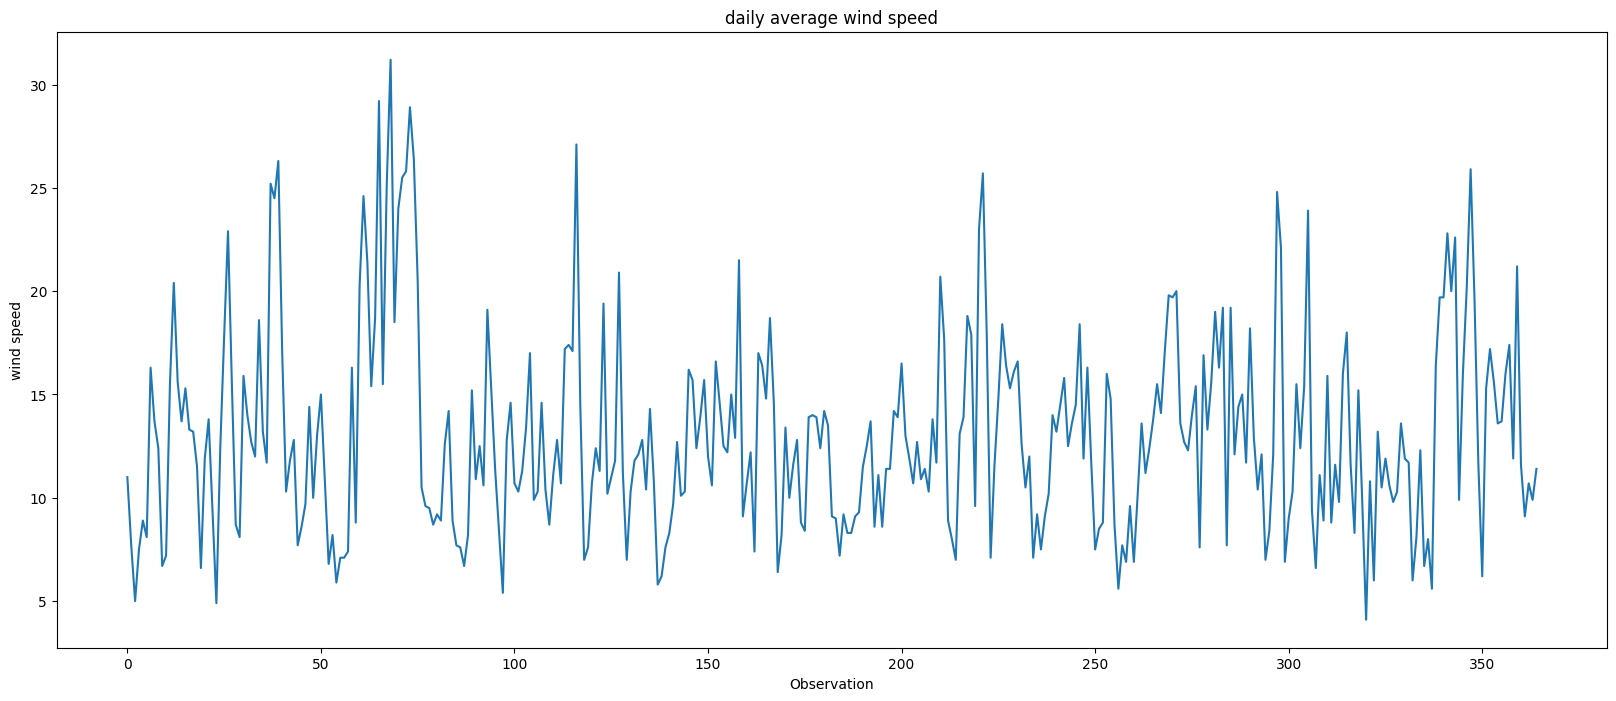

In [8]:
fig = plt.figure(figsize=[20, 8])
ax = fig.add_subplot(1, 1, 1)
ax.plot(wind_speed['windspeed'][0:365])
ax.set_xlabel('Observation')
ax.set_ylabel('wind speed')
ax.set_title('daily average wind speed')

Text(0.5, 1.0, '-0.02178141804508097')

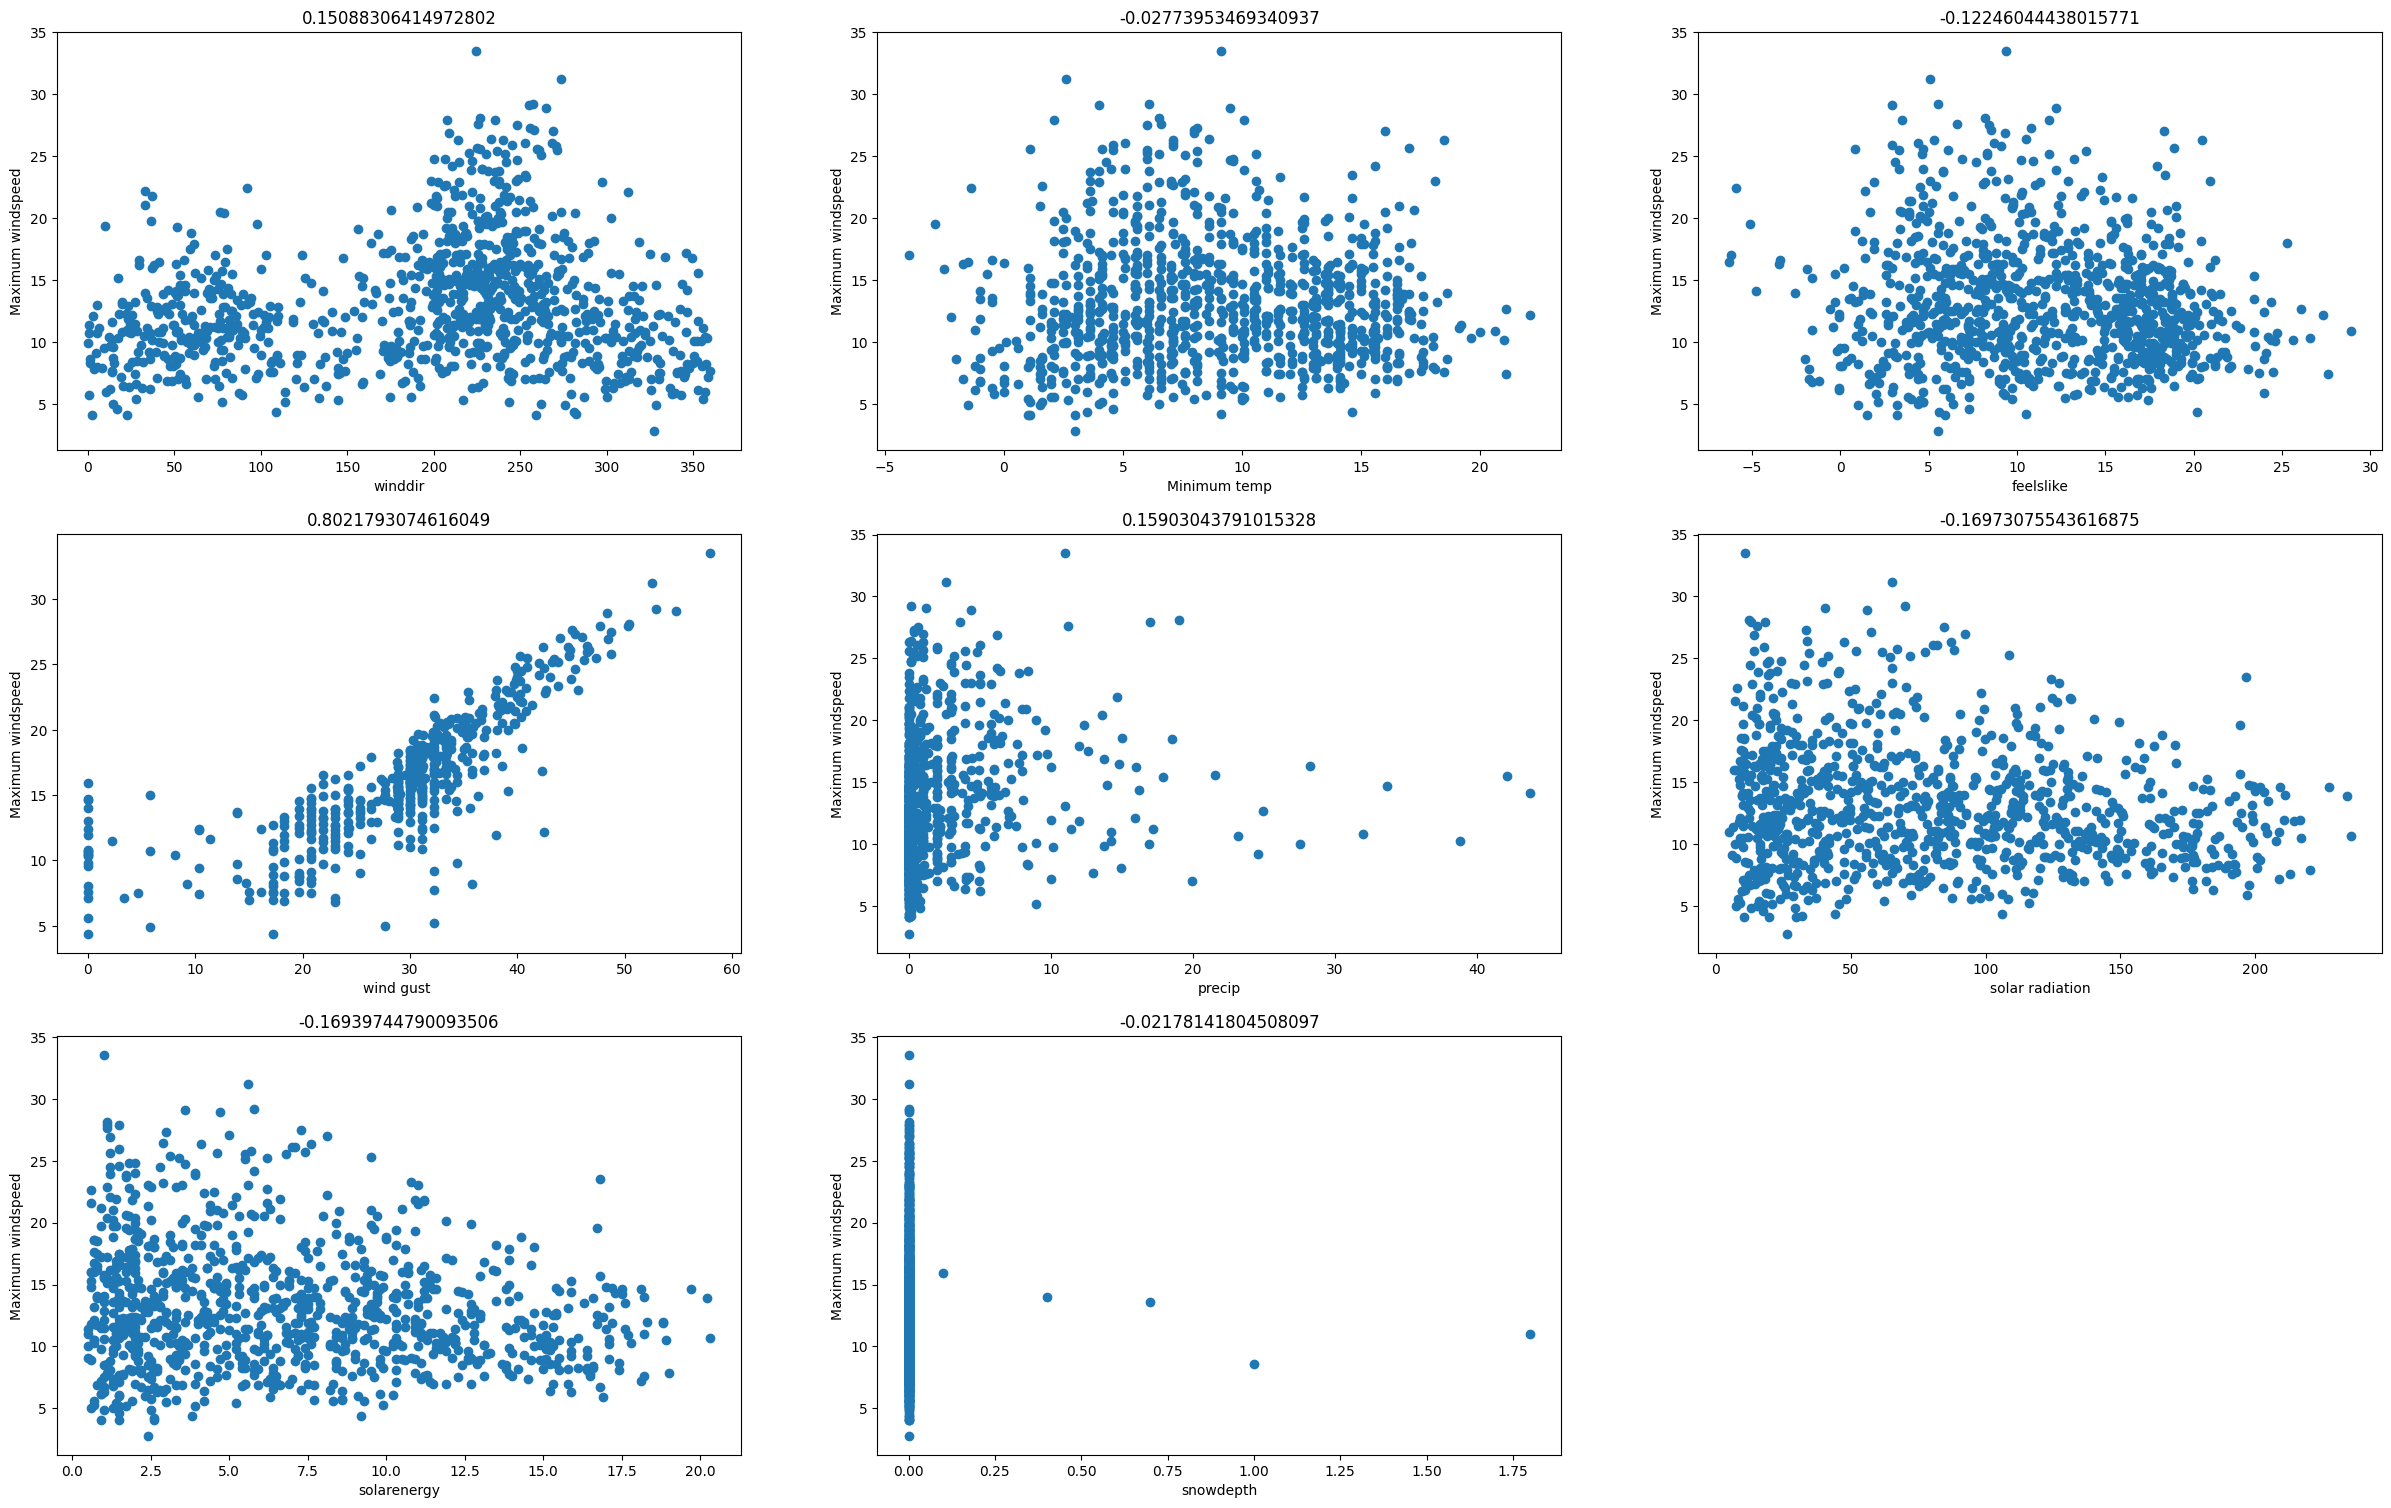

In [9]:
fig = plt.figure(figsize=[30, 25])
ax = fig.add_subplot(4, 3, 1)
ax.scatter(wind_speed['winddir'], wind_speed['windspeed'])
ax.set_xlabel('winddir')
ax.set_ylabel('Maximum windspeed')
ax.set_title(str(wind_speed['windspeed'].corr(wind_speed['winddir'])))

ax = fig.add_subplot(4, 3, 2)
ax.scatter(wind_speed['tempmin'], wind_speed['windspeed'])
ax.set_xlabel('Minimum temp')
ax.set_ylabel('Maximum windspeed')
ax.set_title(str(wind_speed['windspeed'].corr(wind_speed['tempmin'])))

ax = fig.add_subplot(4, 3, 3)
ax.scatter(wind_speed['feelslike'], wind_speed['windspeed'])
ax.set_xlabel('feelslike')
ax.set_ylabel('Maximum windspeed')
ax.set_title(str(wind_speed['windspeed'].corr(wind_speed['feelslike'])))

ax = fig.add_subplot(4, 3, 4)
ax.scatter(wind_speed['windgust'], wind_speed['windspeed'])
ax.set_xlabel('wind gust ')
ax.set_ylabel('Maximum windspeed')
ax.set_title(str(wind_speed['windspeed'].corr(wind_speed['windgust'])))

ax = fig.add_subplot(4, 3, 5)
ax.scatter(wind_speed['precip'], wind_speed['windspeed'])
ax.set_xlabel('precip')
ax.set_ylabel('Maximum windspeed')
ax.set_title(str(wind_speed['windspeed'].corr(wind_speed['precip'])))

ax = fig.add_subplot(4, 3, 6)
ax.scatter(wind_speed['solarradiation'], wind_speed['windspeed'])
ax.set_xlabel('solar radiation')
ax.set_ylabel('Maximum windspeed')
ax.set_title(str(wind_speed['windspeed'].corr(wind_speed['solarradiation'])))

ax = fig.add_subplot(4, 3, 7)
ax.scatter(wind_speed['solarenergy'], wind_speed['windspeed'])
ax.set_xlabel('solarenergy')
ax.set_ylabel('Maximum windspeed')
ax.set_title(str(wind_speed['windspeed'].corr(wind_speed['solarenergy'])))

ax = fig.add_subplot(4, 3, 8)
ax.scatter(wind_speed['snowdepth'], wind_speed['windspeed'])
ax.set_xlabel('snowdepth')
ax.set_ylabel('Maximum windspeed')
ax.set_title(str(wind_speed['windspeed'].corr(wind_speed['snowdepth'])))


Text(0.5, 1.0, '0.9997482617668604')

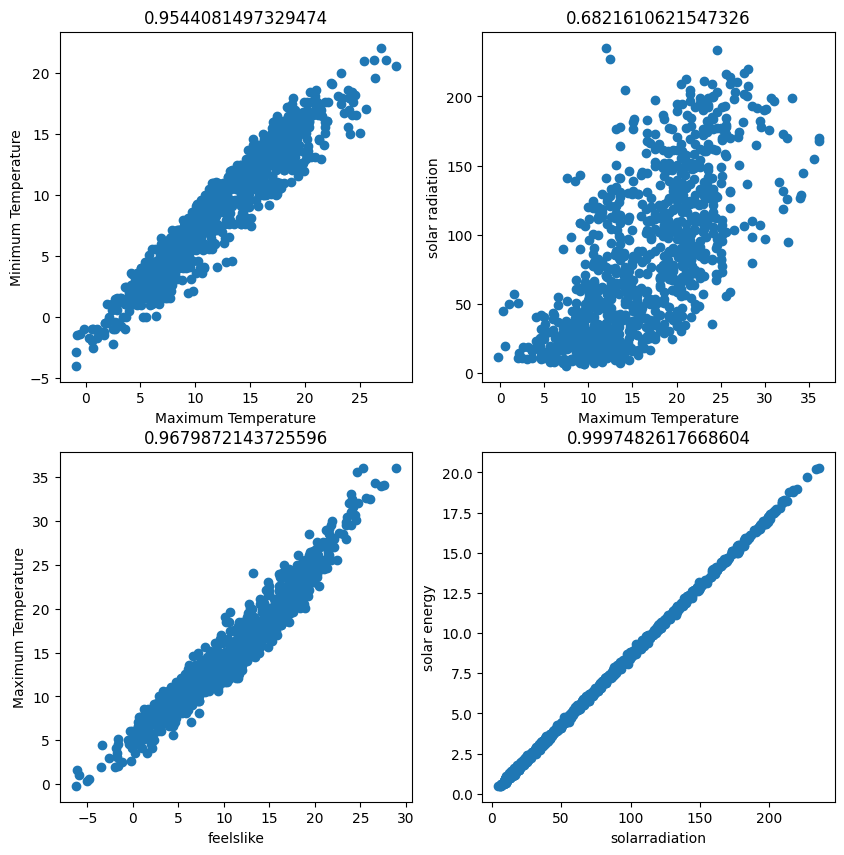

In [10]:
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(2, 2, 1)
ax.scatter(wind_speed['temp'], wind_speed['tempmin'])
ax.set_xlabel('Maximum Temperature')
ax.set_ylabel('Minimum Temperature')
ax.set_title(str(wind_speed['tempmin'].corr(wind_speed['temp'])))

ax = fig.add_subplot(2, 2, 2)
ax.scatter(wind_speed['tempmax'], wind_speed['solarradiation'])
ax.set_xlabel('Maximum Temperature')
ax.set_ylabel('solar radiation')
ax.set_title(str(wind_speed['solarradiation'].corr(wind_speed['tempmax'])))

ax = fig.add_subplot(2, 2, 3)
ax.scatter(wind_speed['feelslike'], wind_speed['tempmax'])
ax.set_xlabel('feelslike')
ax.set_ylabel('Maximum Temperature')
ax.set_title(str(wind_speed['tempmax'].corr(wind_speed['feelslike'])))

ax = fig.add_subplot(2, 2, 4)
ax.scatter(wind_speed['solarradiation'], wind_speed['solarenergy'])
ax.set_xlabel('solarradiation')
ax.set_ylabel('solar energy')
ax.set_title(str(wind_speed['solarradiation'].corr(wind_speed['solarenergy'])))

/var/folders/ck/7hlyx__x35qc46y2y16bktk80000gn/T/ipykernel_16003/2892719482.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(wind_speed.corr(), annot=True, cmap='coolwarm', fmt=".2f")


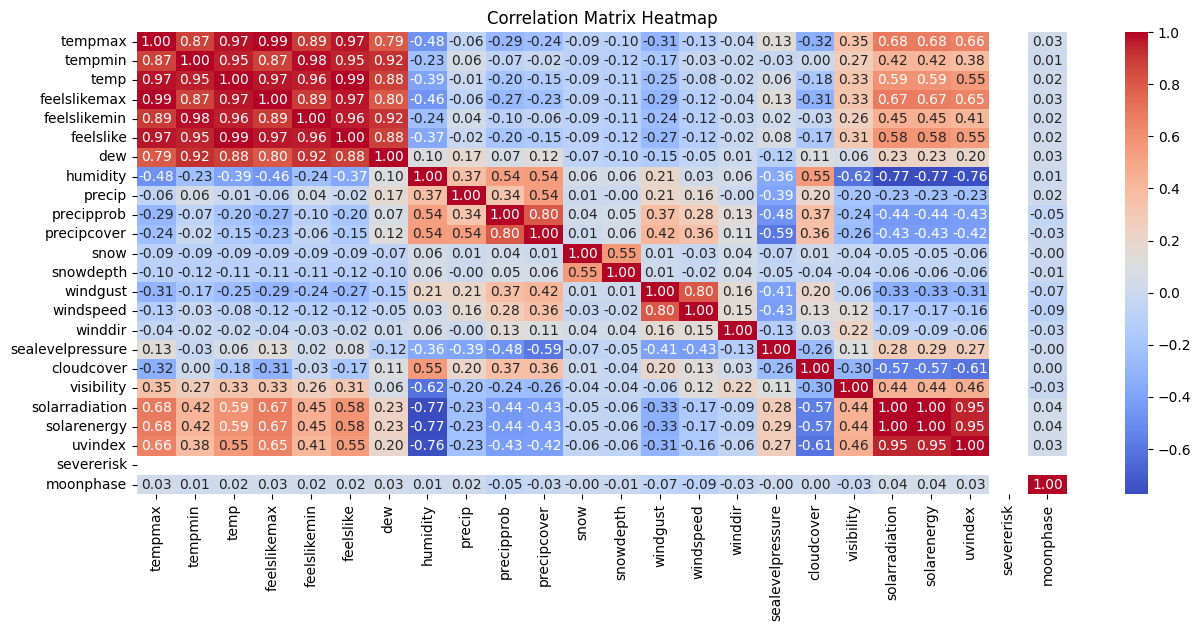

In [11]:
plt.figure(figsize=(15, 6))
sns.heatmap(wind_speed.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

In [12]:
columns_to_remove = ['windgust','precip','snow','dew','precipcover','sealevelpressure','moonphase','visibility','snowdepth','icon','precipprob','uvindex','cloudcover','name','datetime','severerisk', 'preciptype', 'sunrise', 'sunset', 'conditions', 'description', 'stations']
wind_speed = wind_speed.drop(columns = columns_to_remove)
wind_speed = wind_speed.dropna()

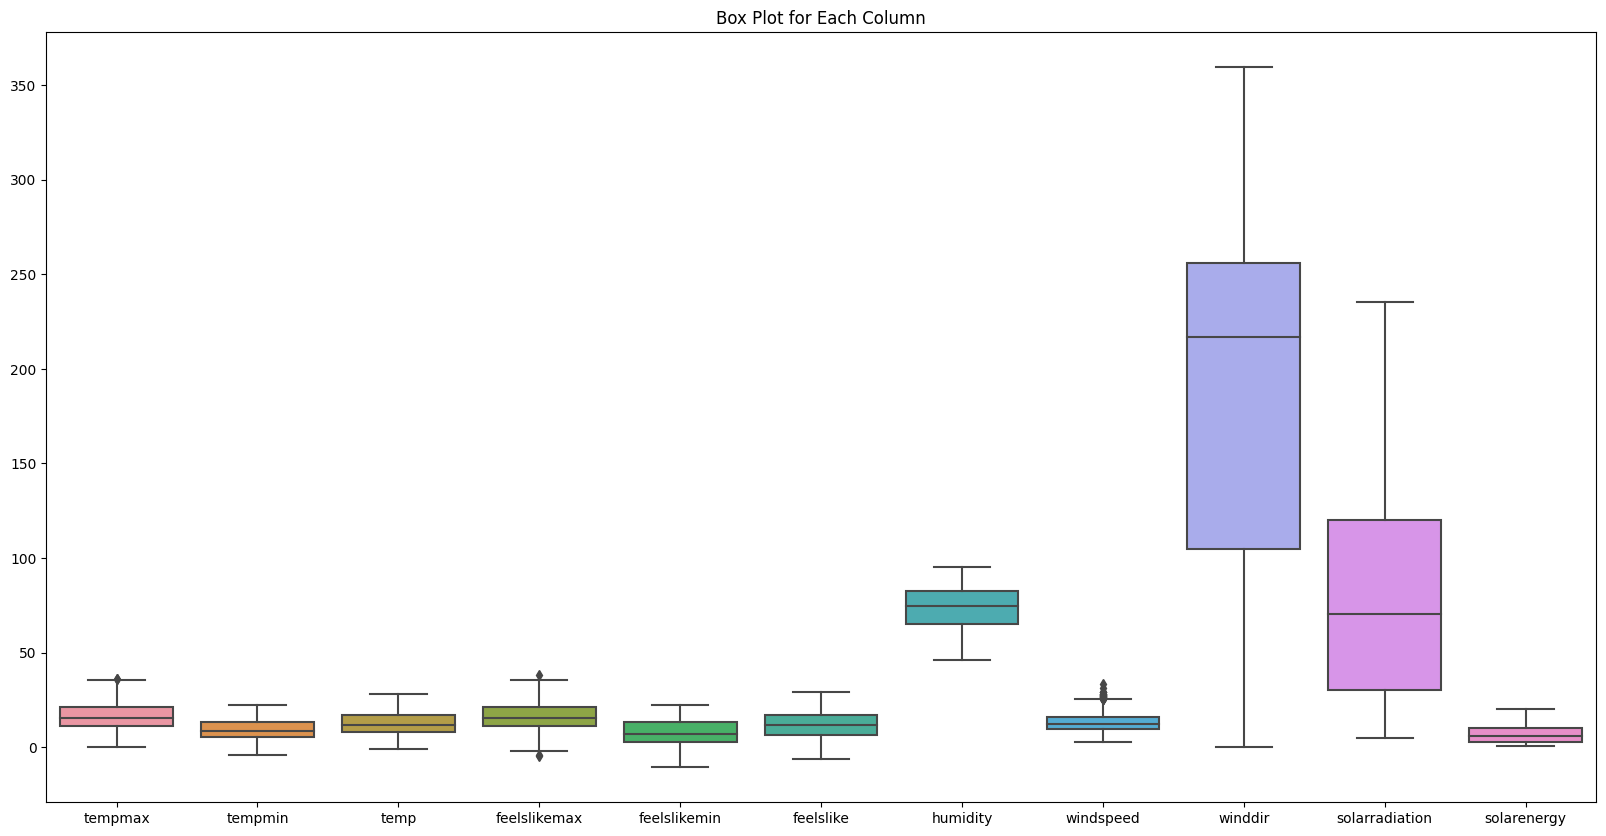

In [13]:
plt.figure(figsize=(20, 10))
sns.boxplot(data=wind_speed)
plt.title('Box Plot for Each Column')
plt.show()

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
wind_speed = pd.DataFrame(scaler.fit_transform(wind_speed), index = wind_speed.index, columns = wind_speed.columns)
x = wind_speed.drop(columns = 'windspeed')
y = wind_speed['windspeed']


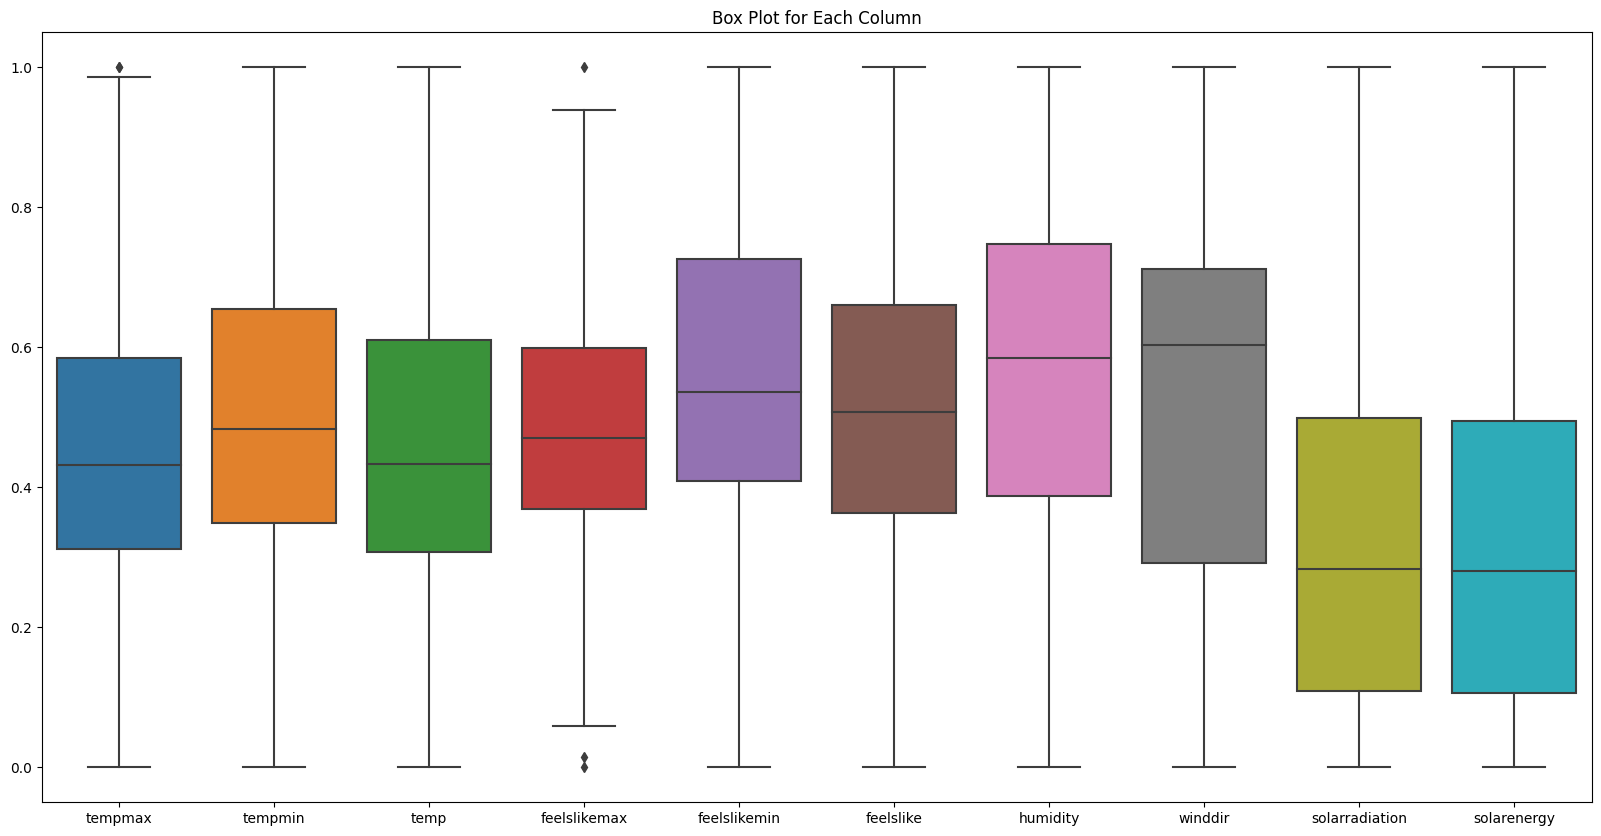

In [15]:
plt.figure(figsize=(20, 10))
sns.boxplot(data= x)
plt.title('Box Plot for Each Column')
plt.show()

In [16]:
train_samples = int(len(x)*0.6)
val_samples = int(len(x) * 0.2)

x_train = x.iloc[:train_samples, :]
y_train = y.iloc[:train_samples]
x_val = x.iloc[train_samples:(train_samples + val_samples), :]
y_val = y.iloc[train_samples:(train_samples + val_samples)]
x_test = x.iloc[(train_samples + val_samples):, :]
y_test = y.iloc[(train_samples + val_samples):]

print(x_train.shape)
x_test.shape

(600, 10)


(200, 10)

In [17]:
# Function to create sequences for time series forecasting
def create_sequences(data, target, time_steps=1):
    x, y = [], []
    for i in range(len(data) - time_steps):
        x.append(data[i:(i + time_steps)])
        y.append(target[i + time_steps])
    return np.array(x), np.array(y)

# Define the number of time steps
time_steps = 1

# Create sequences for training data
x_train_seq, y_train_seq = create_sequences(np.array(x_train), np.array(y_train), time_steps)

x_val_seq, y_val_seq = create_sequences(np.array(x_val), np.array(y_val), time_steps)

# Create sequences for test data
x_test_seq, y_test_seq = create_sequences(np.array(x_test), np.array(y_test), time_steps)

# Reshape the data for compatibility with neural networks
x_train_seq = x_train_seq.reshape((x_train_seq.shape[0], 1, x_train_seq.shape[2]))
x_test_seq = x_test_seq.reshape((x_test_seq.shape[0], 1, x_test_seq.shape[2]))
x_val_seq = x_val_seq.reshape((x_val_seq.shape[0], 1, x_val_seq.shape[2]))

In [18]:
print(x_test_seq.shape)
print(y_test_seq.shape)

(199, 1, 10)
(199,)


In [19]:
tf.random.set_seed(7)

In [21]:
model = Sequential()
model.add(LSTM(64, input_shape=(time_steps, 10)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


#Train the model
history = model.fit(x_train_seq, y_train_seq, epochs=50, batch_size=1, validation_data= [x_val_seq, y_val_seq])

Epoch 1/50
599/599 [==============================] - 3s 3ms/step - loss: 0.0342 - val_loss: 0.0324
Epoch 2/50
599/599 [==============================] - 1s 2ms/step - loss: 0.0286 - val_loss: 0.0303
Epoch 3/50
599/599 [==============================] - 1s 2ms/step - loss: 0.0281 - val_loss: 0.0260
Epoch 4/50
599/599 [==============================] - 1s 2ms/step - loss: 0.0279 - val_loss: 0.0265
Epoch 5/50
599/599 [==============================] - 1s 2ms/step - loss: 0.0284 - val_loss: 0.0251
Epoch 6/50
599/599 [==============================] - 1s 2ms/step - loss: 0.0274 - val_loss: 0.0250
Epoch 7/50
599/599 [==============================] - 1s 2ms/step - loss: 0.0276 - val_loss: 0.0249
Epoch 8/50
599/599 [==============================] - 1s 2ms/step - loss: 0.0275 - val_loss: 0.0270
Epoch 9/50
599/599 [==============================] - 1s 2ms/step - loss: 0.0269 - val_loss: 0.0283
Epoch 10/50
599/599 [==============================] - 1s 2ms/step - loss: 0.0269 - val_loss: 0.0264

In [22]:
pred_1 = model.predict(x_test_seq)

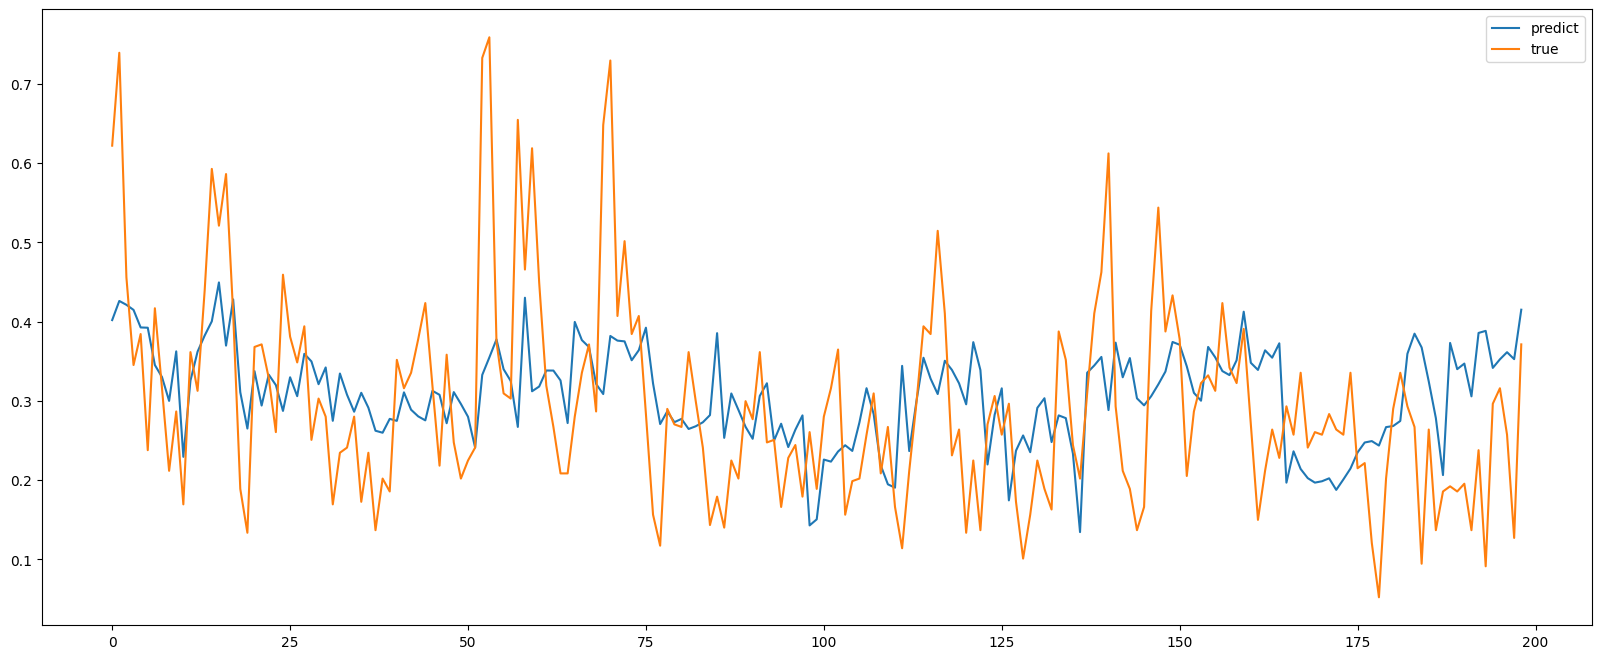

In [24]:
plt.figure(figsize=(20,8))
plt.plot(pred_1, label='predict')
plt.plot(y_test_seq, label='true')
plt.legend()
plt.show()

In [30]:
print("Mean squared error: %.3f" % mean_squared_error(y_test_seq, pred_1))
print('Rsquared : %.3f' % r2_score(y_test_seq, pred_1))
print("Root mean squared error: %.3f" % np.sqrt(mean_squared_error(y_test_seq, pred_1)))

Mean squared error: 0.015
Rsquared : 0.114
Root mean squared error: 0.121


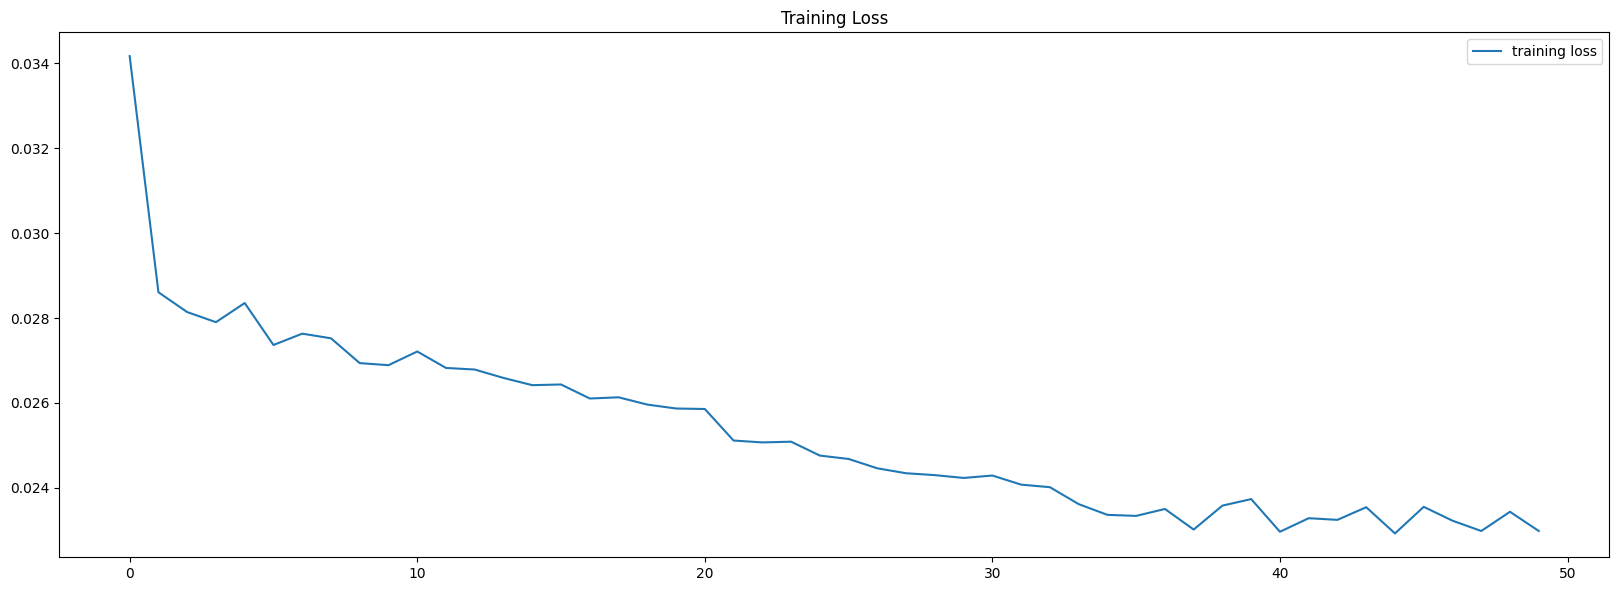

In [37]:
fig = plt.figure(figsize=[20, 15])
ax = fig.add_subplot(2, 1, 1)
ax.plot(history.history['loss'], label="training loss")
plt.title('Training Loss')
ax.legend()

KeyError: 'mae'

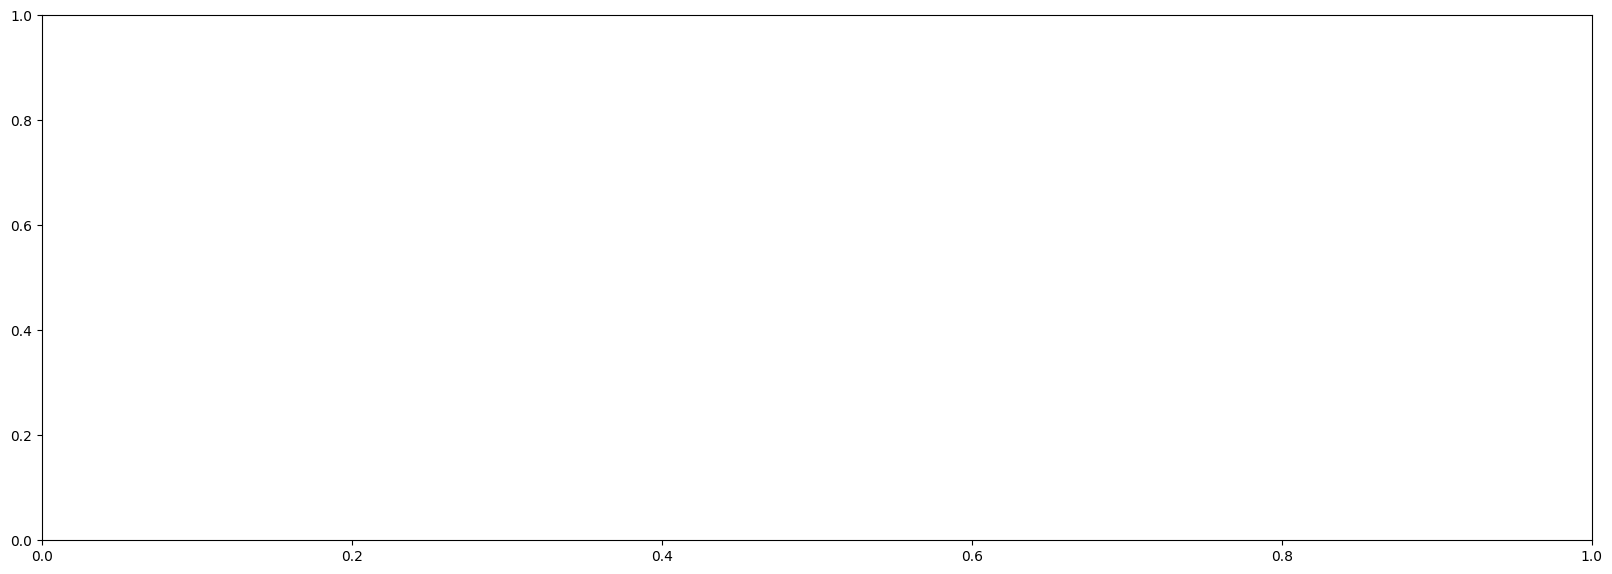

In [38]:
fig = plt.figure(figsize=[20, 15])
ax = fig.add_subplot(2, 1, 1)
ax.plot(history.history['mae'], label= "Training Accuracy")

ax.plot(history.history['val_mae'], label="Validation Accuracy")
plt.title('Training Accuracy and Validation Accuracy')
ax.legend()

In [ ]:
loss = history.history['mae']
val_loss = history.history['val_mae']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Accuracy')
plt.plot(epochs, val_loss, label='Validation Accuracy')
plt.title('Accuracy and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show();

In [ ]:
x_train.info

In [ ]:
linear_model = sm.OLS(y_train, x_train)
trained_model = linear_model.fit()


pred = trained_model.predict(x_test)
#mse_val = mean_squared_error(y_test, pred)
#r2 = r2_score(y_test, pred)
#adjr2 = 1 - (1 - r2) * (x_test.shape[0] - 1) / (x_test.shape[0] - x_test.shape[1] - 1)
#print("Model real mean squared error = {}".format(np.sqrt(mse_val)))
#print("R-Squared = {}".format(r2))
#print("Adj R-Squared = {}".format(adjr2))
print(trained_model.summary())

In [ ]:
fig = plt.figure(figsize=[20, 8])
ax = fig.add_subplot(1, 1, 1)
ax.plot(pred,label="Linear Model Prediction")
ax.plot(y_test,label = " Actual ")
ax.set_ylabel('Maximum windspeed')
ax.legend();

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
order = (1, 1, 2)  
model = ARIMA(y_train, order=order)
model_fit = model.fit()
print(model_fit.summary())

